In [1]:
import dicom
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path
import tensorflow as tf
import numpy as np
from tqdm import tqdm_notebook
import scipy.misc
from skimage import io
import scipy.stats
import seaborn as sns
import skimage.color
from skimage.filters import threshold_otsu
import keras

from matplotlib import animation
from IPython.display import HTML
from PIL import Image
import pandas as pd
import nibabel as nib
from nibabel.testing import data_path

realigned_atlas = nib.load('../../Data/big_atlas/coregistered_pig_2_atlas.nii').get_data()
original_atlas = nib.load('../../Data/big_atlas/atlas.nii').get_data()
anatomical = nib.load('../../Data/pig_2/coregistered_anatomy.nii').get_data()
mean_fmri = nib.load('../../Data/pig_2/rfmri nii/meanus822-0016-00001-000001-01.nii').get_data()  

# let's try loading the entire thing to ram
# the big tensor will have dimension [time, height, width, depth]

im = mean_fmri
all_data = np.zeros((300, im.shape[0], im.shape[1], im.shape[2]))
masked_data = np.ma.zeros((300, im.shape[0], im.shape[1], im.shape[2]))

dicom_files = [x for x in Path('../../Data/pig_2/rfmri files/').iterdir() if x.is_file() and not 'ds_store' in str(x).lower()]
dicom_files.sort(key=str)
time_index = 0

brain_mask = np.ma.masked_where(np.isin(realigned_atlas, [0]), realigned_atlas)

posterior_cingulate_cortex = [131,231,223,123]
posterior_cingulate_cortex_indices = []
posterior_cingulate_cortex_mask = np.ma.masked_where(np.isin(realigned_atlas, posterior_cingulate_cortex, invert=True), realigned_atlas)

prefrontal_cortex = [109,110,209,210]
prefrontal_cortex_indices = []
prefrontal_cortex_mask = np.ma.masked_where(np.isin(realigned_atlas, prefrontal_cortex, invert=True), realigned_atlas)

auditory_cortex = [141,241]
auditory_cortex_indices = []
auditory_cortex_mask = np.ma.masked_where(np.isin(realigned_atlas, auditory_cortex, invert=True), realigned_atlas)

temporal_gyri = [120,121,122,220,221,222]
temporal_gyri_indices = []
temporal_gyri_mask = np.ma.masked_where(np.isin(realigned_atlas, temporal_gyri, invert=True), realigned_atlas)

for f in tqdm_notebook(dicom_files):
    time_file = nib.load(str(f)).get_data()
    fmri_masked_roi = np.ma.masked_where(np.ma.getmask(brain_mask), time_file) 
    try:
        masked_data[time_index, ...] = fmri_masked_roi
        all_data[time_index, ...] = time_file
        time_index += 1
    except:
        print(f)
        
assert all_data.shape == (300, 128, 128, 20)
assert masked_data.shape == (300, 128, 128, 20)# basic sanity check

indices = masked_data[1,:,:,:].nonzero()

df_index = pd.MultiIndex.from_tuples(list(zip(*indices)), names=['row', 'col', 'depth'])
series_df = pd.Series(index=df_index, dtype=object)

for i, triple in tqdm_notebook(enumerate(zip(*indices)), total=len(indices[0])):
    x, y, z = triple
    trace = all_data[:, x, y, z]
    series_df.loc[triple] = trace
    if isinstance(posterior_cingulate_cortex_mask[x,y,z],np.uint8):
        posterior_cingulate_cortex_indices.extend([i])
    if isinstance(auditory_cortex_mask[x,y,z],np.uint8):
        auditory_cortex_indices.extend([i])
    if isinstance(prefrontal_cortex_mask[x,y,z],np.uint8):
        prefrontal_cortex_indices.extend([i])
    if isinstance(temporal_gyri_mask[x,y,z],np.uint8):
        temporal_gyri_indices.extend([i])

data_block = np.vstack(series_df.values)[..., np.newaxis]


Using TensorFlow backend.


In [4]:
squished_embeddings = np.load('../../Data/numpy-data/e11g-embeddings-squished.npy')
print(squished_embeddings.shape)

(7155, 160)


In [5]:
print(anatomical.shape)

(128, 128, 20)


[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 7155 samples in 0.056s...
[t-SNE] Computed neighbors for 7155 samples in 5.405s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7155
[t-SNE] Computed conditional probabilities for sample 2000 / 7155
[t-SNE] Computed conditional probabilities for sample 3000 / 7155
[t-SNE] Computed conditional probabilities for sample 4000 / 7155
[t-SNE] Computed conditional probabilities for sample 5000 / 7155
[t-SNE] Computed conditional probabilities for sample 6000 / 7155
[t-SNE] Computed conditional probabilities for sample 7000 / 7155
[t-SNE] Computed conditional probabilities for sample 7155 / 7155
[t-SNE] Mean sigma: 0.326585
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.802937
[t-SNE] Error after 1000 iterations: 0.536186


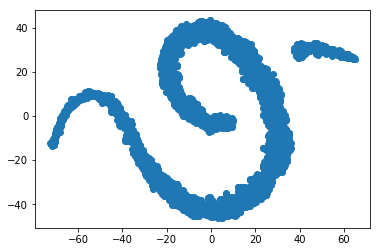

In [10]:
from sklearn import manifold
from time import time

tsne = manifold.TSNE(n_components=2, init='random', random_state=0, n_iter=1000, perplexity=100, verbose=1)
tsne_result = tsne.fit_transform(squished_embeddings)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1])
np.save('../../Data/numpy-data/e11g_tsne_50_pig_2_full_dataset.npy', tsne_result) 


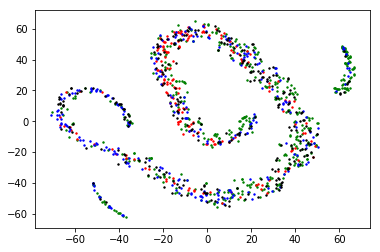

In [9]:
for i in range(len(prefrontal_cortex_indices)):
    plt.scatter(tsne_result[prefrontal_cortex_indices[i],0], tsne_result[prefrontal_cortex_indices[i],1], c='green', s=2)
for i in range(len(posterior_cingulate_cortex_indices)):
    plt.scatter(tsne_result[posterior_cingulate_cortex_indices[i],0], tsne_result[posterior_cingulate_cortex_indices[i],1], c='red', s=2)
for i in range(len(auditory_cortex_indices)):
    plt.scatter(tsne_result[auditory_cortex_indices[i],0], tsne_result[auditory_cortex_indices[i],1], c='blue', s=2)
for i in range(len(temporal_gyri_indices)):
    plt.scatter(tsne_result[temporal_gyri_indices[i],0], tsne_result[temporal_gyri_indices[i],1], c='black', s=2)


plt.savefig('../../Results/tsne_e11/g_tsne_50_pig_2_full_dataset.png')

 

In [6]:
print(len(temporal_gyri_indices))
print(len(posterior_cingulate_cortex_indices))
print(len(auditory_cortex_indices))
print(len(prefrontal_cortex_indices))

279
181
278
485


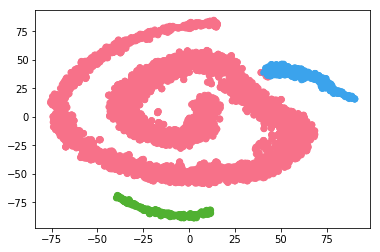

In [108]:
# color (kmeans) and label
from sklearn.cluster import KMeans, DBSCAN

db = DBSCAN(eps=10,min_samples=100)
db.fit_predict(tsne_result)
labels = db.labels_
rgbs = [np.array(c) for c in sns.color_palette("husl", len(np.unique(labels)))]
colors = [rgbs[i] for i in labels]

plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=colors)



[0 0 0 ..., 0 1 1]


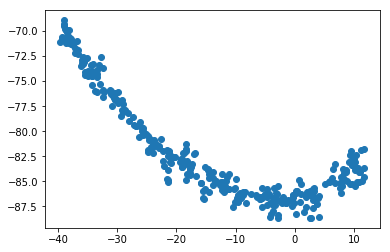

In [109]:

small_island = tsne_result[labels == 1]
plt.scatter(small_island[:,0], small_island[:,1])

In [110]:
slice_i = 0
plt.figure(figsize=(20,10))

small_island_indices = series_df.index[:][labels == 1]
second_island_indices = series_df.index[:][labels == 2]

for slice_i in range(realigned_atlas.shape[2]):
#     plt.subplot(2, 2, 1)
#     plt.imshow(all_data[0, :, :, slice_i], cmap='viridis')

#     plt.subplot(2, 2, 2)
#     plt.imshow(anatomical[:,:,slice_i], cmap='viridis')
#     for p in small_island_indices:
#         if p[2] == slice_i:
#             pass
#             plt.scatter(x=p[1], y=p[0], c='r', s=3)
    
#     plt.subplot(2, 2, 3)
    plt.imshow(all_data[120, :,:,slice_i], cmap='viridis')
    for p in small_island_indices:
        if p[2] == slice_i:
            pass
            plt.scatter(x=p[1], y=p[0], c='r', s=3)
            
    plt.savefig('../../Results/Pig 2 TSNE/Experiment 11e 2/slice_' + str(slice_i) + '.png')
    plt.close('all')
    
    



In [114]:
roi_dict = {'Posterior_commissure': 1,
        'Anterior_commisure':   2,
        'Optic_chiasm':   3,
        'Corpus_callosum':   4,
        'Anteroventral_thalamic_nucleus_1':   5,
        'Anteroventral_thalamic_nucleus_2':   6,
        'Central_thalamic_nucleus_1':   7,
        'Central_thalamic_nucleus_2':   8,
        'Mediodorsal_thalamic_nucleus_1':   9,
        'Mediodorsal_thalamic_nucleus_2':  10,
        'Laterodorsal_thalamic_nucleus_1':  11,
        'Laterodorsal_thalamic_nucleus_2':  12,
        'Geniculate_nuclei_1':  13,
        'Geniculate_nuclei_2':  14,
        'Pulvinar_nuclei_1':  15,
        'Pulvinar_nuclei_2':  16,
        'Reticular_thalamic_nucleus_1':  17,
        'Reticular_thalamic_nucleus_2':  18,
        'Ventral_anterior_thalamic_nucleus_1':  19,
        'Ventral_anterior_thalamic_nucleus_2':  20,
        'Ventral_posterior_thalamic_nucleus_1':  21,
        'Ventral_posterior_thalamic_nucleus_2':  22,
        'Accumbens_nucleus_1':  23,
        'Accumbens_nucleus_2':  24,
        'Caudate_nucleus_1':  25,
        'Caudate_nucleus_2':  26,
        'Claustrum_1':  27,
        'Claustrum_2':  28,
        'Globus_pallidus_1':  29,
        'Globus_pallidus_2':  30,
        'Putamen_1':  31,
        'Putamen_2':  32,
        'Substantia_nigra_1':  33,
        'Substantia_nigra_2':  34,
        'Fornix':  35,
        'Hippocampus_1':  36,
        'Hippocampus_2':  37,
        'Subiculum_1':  38,
        'Subiculum_2':  39,
        'Amygdala_1':  40,
        'Amygdala_2':  41,
        'Subthalamic_nucleus_1':  42,
        'Subthalamic_nucleus_2':  43,
        'Zona_incerta_1':  44,
        'Zona_incerta_2':  45,
        'Habenular_nuclei_1':  46,
        'Habenular_nuclei_2':  47,
        'Pineal_gland':  48,
        'Anteriror_hypothalamic_area_1':  49,
        'Anteriror_hypothalamic_area_2':  50,
        'Mamillary_body':  51,
        'Medial_hypothalamic_area_1':  52,
        'Medial_hypothalamic_area_2':  53,
        'Inferior_colliculus_1':  54,
        'Inferior_colliculus_2':  55,
        'Superior_colliculus_1':  56,
        'Superior_colliculus_2':  57,
        'Periaqueductal_gray':  58,
        'Red_nucleus_1':  59,
        'Red_nucleus_2':  60,
        'Nucleus_of_the_optic_tract_1':  61,
        'Nucleus_of_the_optic_tract_2':  62,
        'Pretectal_area_1':  63,
        'Pretectal_area_2':  64,
        'Interpeduncular_nucleus':  65,
        'Pontine_nuclei_1': 66,
        'Pontine_nuclei_2':  67,
        'Reticulotegmental_nucleus_1':  68,
        'Reticulotegmental_nucleus_2':  69,
        'Cuneate_nucleus_1':  70,
        'Cuneate_nucleus_2':  71,
        'Nucleus_of_the_solitary_tract_1':  72,
        'Nucleus_of_the_solitary_tract_2':  73,
        'Olivary_nuclei_1':  74,
        'Olivary_nuclei_2':  75,
        'Superior_olivary_complex_1':  76,
        'Superior_olivary_complex_2':  77,
        'Dorsal_motor_nucleus_of_vagus_1':  78,
        'Dorsal_motor_nucleus_of_vagus_2':  79,
        'Motor_trigeminal_nucleus_1':  80,
        'Motor_trigeminal_nucleus_2':  81,
        'Spinal_trigeminal_nucleus_1':  82,
        'Spinal_trigeminal_nucleus_2':  83,
        'Abducens_nucleus_1':  84,
        'Abducens_nucleus_2':  85,
        'Facial_nucleus_1':  86,
        'Facial_nucleus_2':  87,
        'Hypoglossal_nucleus_1':  88,
        'Hypoglossal_nucleus_2':  89,
        'Spinal_trigeminal_tract_1':  90,
        'Spinal_trigeminal_tract_2':  91,
        'Vestibular_nucleus_1':  92,
        'Vestibular_nucleus_2':  93,
        'Lateral_ventricle_1':  94,
        'Lateral_ventricle_2':  95,
        'Third_ventricle':  96,
        'Fourth_ventricle':  97,
        'Cerebral_aqueduct_(Sylvius)':  98,
        'Primary_somatosensory_cortex_1': 101,
        'Primary_somatosensory_cortex_2': 201,
        'Primary_motor_cortex_1': 104,
        'Primary_motor_cortex_2': 204,
        'Somatosensory_association_cortex_1': 105,
        'Somatosensory_association_cortex_2': 205,
        'Premotar_cortex_1': 106,
        'Premotar_cortex_2': 206,
        'Dorsolateral_prefrontal_cortex_1': 109,
        'Dorsolateral_prefrontal_cortex_2': 209,
        'Anterior_prefrontal_cortex_1': 110,
        'Orbitofrontal_cortex_1': 111,
        'Insular_cortex_1': 113,
        'Primary_visual_cortex_(V1)_1': 117,
        'Secondary_visual_cortex_(V2)_1': 118,
        'Associative_visual_cortex_(V3)_1': 119,
        'Inferior_temporal_gyrus_1': 120,
        'Middle_temporal_gyrus_1': 121,
        'Superior_temporal_gyrus_1': 122,
        'Inferior_temporal_gyrus_2': 220,
        'Middle_temporal_gyrus_2': 221,
        'Superior_temporal_gyrus_2': 222,
        'Ventral_posterior_cingulate_cortex_1': 123,
        'Ventral_anterior_cingulate_cortex_2': 124,
        'Ventral_posterior_cingulate_cortex_1': 223,
        'Ventral_anterior_cingulate_cortex_2': 224,
        'Ectosplenial_area_1': 126,
        'Piriform_cortex_1': 127,
        'Retrosplenial_cingular_cortex_1': 129,
        'Dorsal_posterior_cingular_cortex_1': 131,
        'Dorsal_anterior_cingulate_cortex_1': 132,
        'Dorsal_posterior_cingular_cortex_2': 231,
        'Dorsal_anterior_cingulate_cortex_2': 232,
        'Anterior_entorhinal_cortex_1': 134,
        'Perirhinal_cortex_1': 135,
        'Parahippocampal_cortex_1': 136,
        'Fusiform_gyrus_1': 137,
        'Auditory_cortex_1': 141,
        'Auditory_cortex_2': 241,
        'Prepiriform_area_1': 149,
        'Olfactory_bulb_1': 151,
        'Lateral_cerebellar_nucleus_1': 160,
        'Lateral_cerebellar_nucleus_2': 161,
        'Medial_cerebellar_nucleus_1': 162,
        'Medial_cerebellar_nucleus_2': 163,
        'Interposed_cerebellar_nucleus_1': 164,
        'Interposed_cerebellar_nucleus_2': 165,
        'Inferior_cerebellar_peduncle_1': 166,
        'Inferior_cerebellar_peduncle_2': 167,
        'Medial_cerebellar_peduncle_1': 168,
        'Medial_cerebellar_peduncle_2': 169,
        'Superior_cerebellar_peduncle_1': 170,
        'Superior_cerebellar_peduncle_2': 171,
        'Cerebellar_lobule_I,II': 181,
        'Cerebellar_lobule_III': 183,
        'Cerebellar_lobule_IV': 184,
        'Cerebellar_lobule_V': 185,
        'Cerebellar_lobule_VI': 186,
        'Cerebellar_lobule_VIIB': 187,
        'Cerbellar_lobule_VIIIA': 188,
        'Cerebellar_lobule_IX': 189,
        'Cerebellar_lobule_X': 190,
        'Crus1_of_the_ansiform_lobule': 191,
        'Crus2_of_the_ansiform_lobule': 192,
        'Cerebellar_lobule_VIIIB': 193,
        'Anterior_prefrontal_cortex_2': 210,
        'Orbitofrontal_cortex_2': 211,
        'Insular_cortex_2': 213,
        'Primary_visual_cortex_(V1)_2': 217,
        'Secondary_visual_cortex_(V2)_2': 218,
        'Associative_visual_cortex_(V3)_2': 219,
        'Ectosplenial_area_2': 226,
        'Piriform_cortex_2': 227,
        'Retrosplenial_cingular_cortex_2': 229,
        'Anterior_entorhinal_cortex_2': 234,
        'Perirhinal_cortex_2': 235,
        'Parahippocampal_cortex_2': 236,
        'Fusiform_gyrus_2': 237,
        'Prepiriform_area_2': 249,
        'Olfactory_bulb_2': 251}

ivd = {v: k for k, v in roi_dict.items()}

roi_labels = []

for i in small_island_indices:
    label = realigned_atlas[i[0], i[1], i[2]]
    roi_labels.extend([label])
    
unique_labels, counts = np.unique(roi_labels, return_counts=True)

for i in range(unique_labels.size):
    print(str(counts[i]) + ': ' + ivd[unique_labels[i]])
    
    


3: Hippocampus_2
1: Superior_colliculus_2
1: Spinal_trigeminal_tract_2
3: Lateral_ventricle_2
51: Primary_somatosensory_cortex_1
2: Primary_motor_cortex_1
5: Somatosensory_association_cortex_1
14: Dorsolateral_prefrontal_cortex_1
9: Insular_cortex_1
1: Secondary_visual_cortex_(V2)_1
1: Associative_visual_cortex_(V3)_1
1: Inferior_temporal_gyrus_1
2: Middle_temporal_gyrus_1
1: Perirhinal_cortex_1
4: Parahippocampal_cortex_1
9: Auditory_cortex_1
6: Prepiriform_area_1
27: Olfactory_bulb_1
1: Inferior_cerebellar_peduncle_2
1: Medial_cerebellar_peduncle_1
26: Cerebellar_lobule_VIIB
9: Crus2_of_the_ansiform_lobule
69: Primary_somatosensory_cortex_2
3: Primary_motor_cortex_2
2: Somatosensory_association_cortex_2
10: Dorsolateral_prefrontal_cortex_2
3: Insular_cortex_2
9: Secondary_visual_cortex_(V2)_2
1: Associative_visual_cortex_(V3)_2
1: Inferior_temporal_gyrus_2
1: Middle_temporal_gyrus_2
1: Superior_temporal_gyrus_2
2: Perirhinal_cortex_2
8: Parahippocampal_cortex_2
9: Auditory_cortex_2
4

In [113]:
roi_labels = []

for i in second_island_indices:
    label = realigned_atlas[i[0], i[1], i[2]]
    roi_labels.extend([label])
    
unique_labels, counts = np.unique(roi_labels, return_counts=True)

for i in range(unique_labels.size):
    print(str(counts[i]) + ': ' + ivd[unique_labels[i]])
    


3: Geniculate_nuclei_2
2: Fornix
2: Hippocampus_1
1: Hippocampus_2
1: Pineal_gland
1: Pontine_nuclei_1
1: Pontine_nuclei_2
1: Superior_olivary_complex_1
1: Spinal_trigeminal_nucleus_2
6: Lateral_ventricle_1
7: Lateral_ventricle_2
8: Third_ventricle
35: Primary_somatosensory_cortex_1
20: Primary_motor_cortex_1
16: Somatosensory_association_cortex_1
15: Premotar_cortex_1
28: Dorsolateral_prefrontal_cortex_1
28: Anterior_prefrontal_cortex_1
9: Insular_cortex_1
16: Primary_visual_cortex_(V1)_1
15: Secondary_visual_cortex_(V2)_1
3: Dorsal_anterior_cingulate_cortex_1
1: Anterior_entorhinal_cortex_1
6: Perirhinal_cortex_1
8: Auditory_cortex_1
13: Olfactory_bulb_1
4: Crus2_of_the_ansiform_lobule
28: Primary_somatosensory_cortex_2
12: Primary_motor_cortex_2
28: Somatosensory_association_cortex_2
16: Premotar_cortex_2
12: Dorsolateral_prefrontal_cortex_2
18: Anterior_prefrontal_cortex_2
13: Insular_cortex_2
9: Primary_visual_cortex_(V1)_2
8: Secondary_visual_cortex_(V2)_2
1: Associative_visual_c